In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Silencia avisos de Protobuf e CPU

import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, Input
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

print("✅ Ambiente configurado em Modo CPU Seguro para processamento de Keypoints.")
print(f"TensorFlow versão: {tf.__version__}")

/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/attr_value.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/tensor.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at tensorflow/core/framework/resource_handle.proto. Please update the gencode to avoid compatibility violations in the next r

✅ Ambiente configurado em Modo CPU Seguro para processamento de Keypoints.
TensorFlow versão: 2.20.0


In [2]:
# 1. Carregar os dados processados
df = pd.read_csv('../data/processed/biometria_final_pos.csv')

# CORREÇÃO: Captura todas as colunas que começam com 'geo_' e 'img_'
features_cols = [col for col in df.columns if col.startswith(('geo_', 'img_'))]
X = df[features_cols].values
y = df['cow_id'].values

# Escalonamento
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"✅ Dataset expandido: {X_scaled.shape[1]} características (Geometria + Cor + SIFT).")

✅ Dataset expandido: 53 características (Geometria + Cor + SIFT).


In [3]:
def create_pairs(X, y):
    pairs, labels = [], []
    unique_classes = np.unique(y)
    class_indices = [np.where(y == i)[0] for i in unique_classes]
    
    for idx1 in range(len(X)):
        current_class = y[idx1]
        class_idx = np.where(unique_classes == current_class)[0][0]
        
        # Par Positivo (Mesmo ID - Vaca igual)
        idx2 = np.random.choice(class_indices[class_idx])
        pairs += [[X[idx1], X[idx2]]]
        labels += [1] # 1 para "Igual"
        
        # Par Negativo (ID Diferente - Vaca diferente)
        other_class = np.random.choice([c for c in unique_classes if c != current_class])
        other_class_idx = np.where(unique_classes == other_class)[0][0]
        idx3 = np.random.choice(class_indices[other_class_idx])
        pairs += [[X[idx1], X[idx3]]]
        labels += [0] # 0 para "Diferente"
        
    return np.array(pairs), np.array(labels).astype('float32')

pairs, labels = create_pairs(X_scaled, y)
X_train, X_test, y_train, y_test = train_test_split(pairs, labels, test_size=0.2, random_state=42)

print(f"✅ Gerados {len(pairs)} pares para treinamento.")

✅ Gerados 3000 pares para treinamento.


In [4]:
from tensorflow.keras import ops # Importação necessária para Keras 3

def build_geometrical_branch(input_dim):
    """Braço da rede que processa o vetor completo (Keypoints + Cor + SIFT)"""
    model = models.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(256, activation='relu'),
        layers.BatchNormalization(), # Estabiliza o treino com muitas features
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),
        layers.Dense(64, activation='relu') # Embedding final
    ])
    return model

# Usando a dimensão total das colunas (Geo + Img) do seu DataFrame processado
# Certifique-se que X_scaled na Célula 2 foi criado com todas as colunas relevantes
input_dim = X_scaled.shape[1] 
geo_branch = build_geometrical_branch(input_dim)

# Definição das entradas
input_l = Input(shape=(input_dim,), name='input_left')
input_r = Input(shape=(input_dim,), name='input_right')

# Extração de características
feat_l = geo_branch(input_l)
feat_r = geo_branch(input_r)

# SOLUÇÃO DO ERRO: Usando keras.ops para a diferença absoluta
# Se o seu ambiente for Keras 2, use: layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([feat_l, feat_r])
diff = ops.abs(feat_l - feat_r)

# Camada de saída para classificação de similaridade
output = layers.Dense(1, activation='sigmoid', name='similarity_output')(diff)

siamese_model = models.Model(inputs=[input_l, input_r], outputs=output)
siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

siamese_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_left          │ (None, 53)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_right         │ (None, 53)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 64)        │     56,000 │ input_left[0][0], │
│ (Sequential)        │                   │            │ input_right[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ subtract (Subtract) │ (None, 64)        │          0 │ sequential[0][0], │
│                     │                   │            │ sequential[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ absolute (Absolute) │ (None, 64)        │          0 │ subtract[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_output   │ (None, 1)         │         65 │ absolute[0][0]    │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 56,065 (219.00 KB)

 Trainable params: 55,553 (217.00 KB)

 Non-trainable params: 512 (2.00 KB)

In [5]:
print("🚀 Iniciando treinamento da Rede Siamesa Geométrica na GPU...")

history = siamese_model.fit(
    [X_train[:, 0], X_train[:, 1]], y_train,
    validation_data=([X_test[:, 0], X_test[:, 1]], y_test),
    epochs=100,
    batch_size=32,
    verbose=1
)

# Salvar o modelo para a entrega do Mestrado
siamese_model.save('modelo_siames_keypoints.h5')
print("✅ Modelo salvo com sucesso!")

🚀 Iniciando treinamento da Rede Siamesa Geométrica na GPU...
Epoch 1/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.6062 - loss: 0.6663 - val_accuracy: 0.6200 - val_loss: 0.6227
Epoch 2/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7229 - loss: 0.5460 - val_accuracy: 0.7100 - val_loss: 0.5670
Epoch 3/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7600 - loss: 0.5016 - val_accuracy: 0.7183 - val_loss: 0.5700
Epoch 4/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7467 - loss: 0.4921 - val_accuracy: 0.7433 - val_loss: 0.5178
Epoch 5/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7896 - loss: 0.4566 - val_accuracy: 0.7317 - val_loss: 0.5420
Epoch 6/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8012 - loss: 0.4353 - val_accuracy: 0.7533 - val_loss: 0.5143
Epoch 7/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8167 - loss: 0.4094 - val_accuracy: 0.7550 - val_loss: 0.5416
Epoch 8/100
75/75 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step

✅ Modelo salvo com sucesso!


🧐 Avaliando o desempenho no conjunto de teste...
------------------------------
✅ Acurácia de Verificação: 74.50%
🎯 Precisão (Evitar falsos positivos): 72.24%
📢 Recall (Sensibilidade do sistema): 77.89%
------------------------------


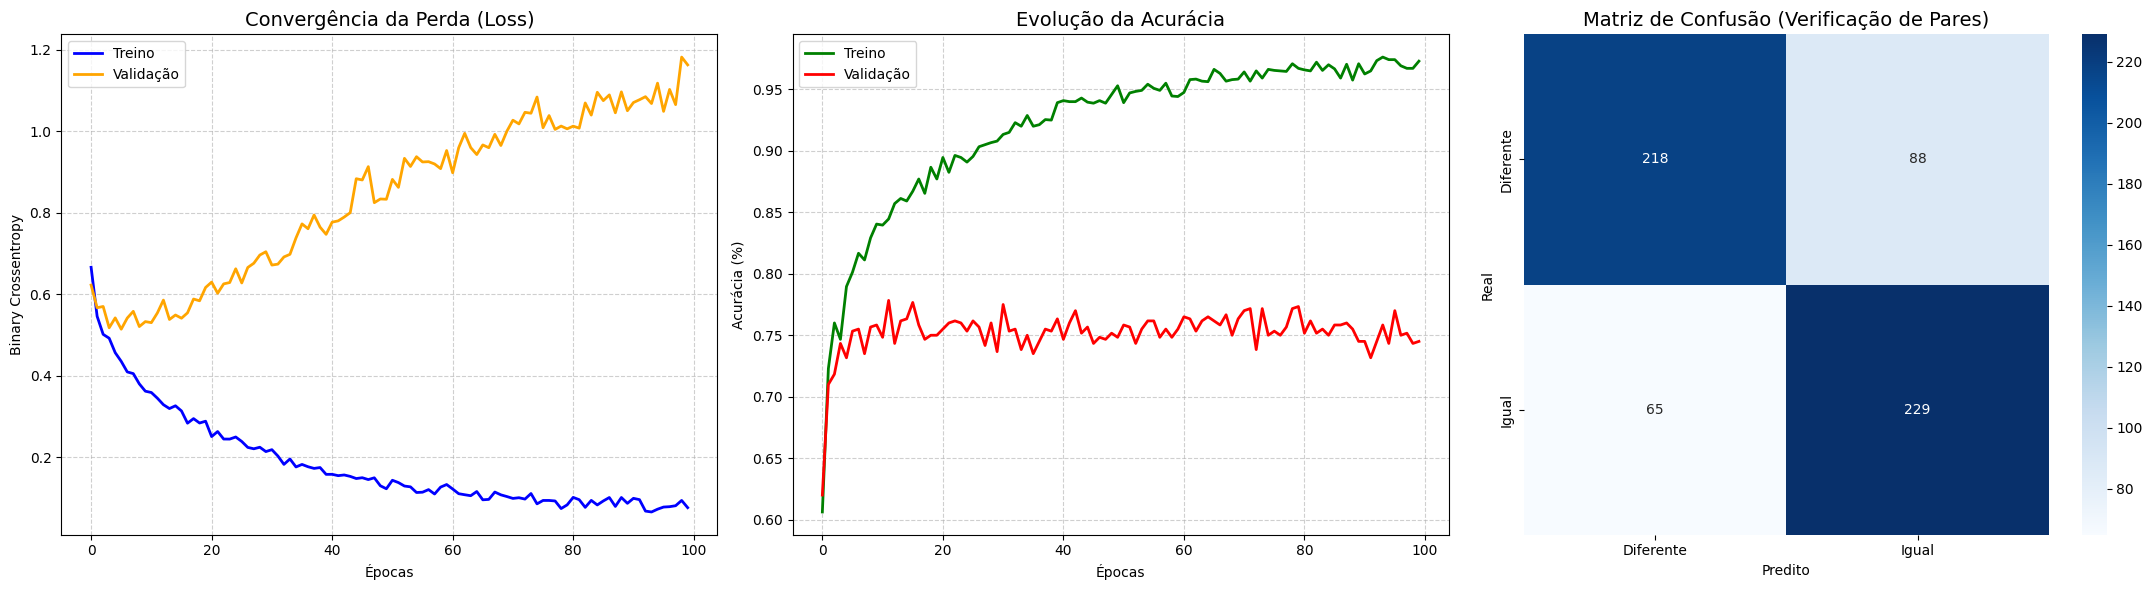


📝 Relatório Detalhado:
                    precision    recall  f1-score   support

Classes Diferentes       0.77      0.71      0.74       306
      Mesmo Animal       0.72      0.78      0.75       294

          accuracy                           0.74       600
         macro avg       0.75      0.75      0.74       600
      weighted avg       0.75      0.74      0.74       600



In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, recall_score, precision_score
import numpy as np

# 1. Gerar Predições no Conjunto de Teste
print("🧐 Avaliando o desempenho no conjunto de teste...")
# A rede recebe o par [Input_Esquerdo, Input_Direito]
y_probs = siamese_model.predict([X_test[:, 0], X_test[:, 1]], verbose=0)
y_pred = (y_probs > 0.5).astype(int).flatten()

# 2. Cálculo de Métricas Adicionais (Rigor de Pós-Graduação)
acc = np.mean(y_pred == y_test)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print("-" * 30)
print(f"✅ Acurácia de Verificação: {acc:.2%}")
print(f"🎯 Precisão (Evitar falsos positivos): {precision:.2%}")
print(f"📢 Recall (Sensibilidade do sistema): {recall:.2%}")
print("-" * 30)

# 3. Plotar Histórico de Treinamento e Matriz de Confusão
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(22, 6))

# Gráfico de Perda (Loss)
ax1.plot(history.history['loss'], label='Treino', color='blue', lw=2)
ax1.plot(history.history['val_loss'], label='Validação', color='orange', lw=2)
ax1.set_title('Convergência da Perda (Loss)', fontsize=14)
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Binary Crossentropy')
ax1.grid(True, linestyle='--', alpha=0.6)
ax1.legend()

# Gráfico de Acurácia
ax2.plot(history.history['accuracy'], label='Treino', color='green', lw=2)
ax2.plot(history.history['val_accuracy'], label='Validação', color='red', lw=2)
ax2.set_title('Evolução da Acurácia', fontsize=14)
ax2.set_xlabel('Épocas')
ax2.set_ylabel('Acurácia (%)')
ax2.grid(True, linestyle='--', alpha=0.6)
ax2.legend()

# Matriz de Confusão (Mesma Vaca vs. Vacas Diferentes)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3, 
            xticklabels=['Diferente', 'Igual'], 
            yticklabels=['Diferente', 'Igual'])
ax3.set_title('Matriz de Confusão (Verificação de Pares)', fontsize=14)
ax3.set_xlabel('Predito')
ax3.set_ylabel('Real')

plt.tight_layout()
plt.show()

# 4. Relatório Final de Classificação
print("\n📝 Relatório Detalhado:")
print(classification_report(y_test, y_pred, target_names=['Classes Diferentes', 'Mesmo Animal']))